Homework 10  -  Advanced SQL Homework  -  Scott Brown

In [1]:
# Dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import scipy.stats as stats

import numpy as np
import pandas as pd

import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, or_

In [2]:
# Engine

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# Making sure the data was brought in correctly

Base=automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [4]:
# Setting variables to the Measurement and Station variables

Measurement=Base.classes.measurement
Station=Base.classes.station

In [5]:
# Filters for the last 12 months of data.
# 2017-08-23 is the final date. 

session=Session(engine)
Date_prcp=session.query(Measurement.date, Measurement.prcp).  \
    filter(Measurement.date < '2017-08-24').  \
    filter(Measurement.date > '2016-08-22').all()

In [88]:
# Dataframe for graph with date set as the index
# 2021 total for count.

Prcp_df=pd.DataFrame(Date_prcp, columns=('date', 'precipitation'))
Prcp_df=Prcp_df.sort_values('date')
Prcp_df=Prcp_df.set_index(['date'])
Prcp_df.count()

precipitation    2021
dtype: int64

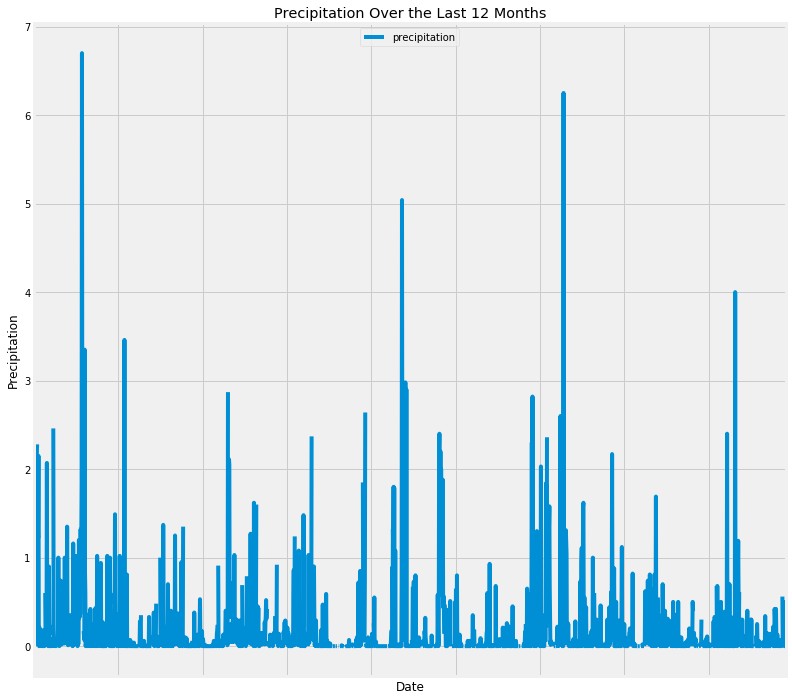

In [97]:
# Graph of Precipitation Data for Last 12 Months

Prcp_graph=Prcp_df.plot(kind='line', grid=True, figsize=(12,12))
lgnd=plt.legend(loc='upper center')


plt.title("Precipitation Over the Last 12 Months")
plt.ylabel("Precipitation")
plt.xlabel('Date')
#plt.gca().get_xaxis().set_visible(False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

In [7]:
# Precipitation statistical summary for last 12 months.
# Check to confirm it matches starter summary data.

Prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [8]:
# Count for total number of unique stations

Station_prcp=session.query(Measurement.station).distinct().count()
Station_prcp

9

In [9]:
# Total unique stations and their respective number of temperature observations.

Station_total_prcp=session.query(  \
            Measurement.station, func.count(Measurement.station)).  \
            group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).  \
            distinct().all()



Station_total_prcp

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [10]:
# Station with most temperature observations.

Station_total_prcp_first=session.query(  \
            Measurement.station).  \
            group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).  \
            distinct().first()



Station_total_prcp_first

('USC00519281')

In [11]:
# Station with most observation is USC00519281.
# Stats for this station.


Max_station_stats=session.query(  \
        func.min(Measurement.tobs), 
        func.max(Measurement.tobs), 
        func.avg(Measurement.tobs)).  \
        filter(Measurement.station==Station_total_prcp[0][0]).  \
        group_by(Measurement.station).all()




Max_station_stats

[(54.0, 85.0, 71.66378066378067)]

In [12]:
# Histogram DataFrame.  Last 12 months of temperature data for
# station USC00519281.

session=Session(engine)
Temp_281=session.query(Measurement.station, Measurement.tobs). \
    filter(Measurement.date < '2017-08-24').  \
    filter(Measurement.date > '2016-08-22').  \
    filter(Measurement.station==Station_total_prcp[0][0]).all()
    
    
    
Temp_281_df=pd.DataFrame(Temp_281)
Temp_281_df=Temp_281_df.set_index('station')
Temp_281_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


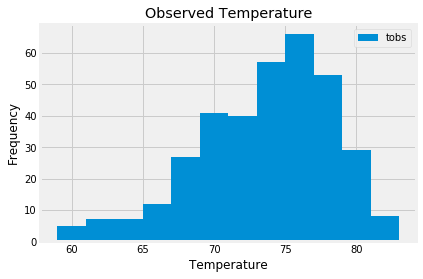

In [100]:
# Temperature Observations for Station USC00519281.


hist_281=Temp_281_df[["tobs"]].plot(kind='hist', bins=12, rwidth=1.0)

plt.title("Observed Temperature")
plt.xlabel("Temperature")
plt.savefig("281 Temperature Histogram")
plt.show()

In [98]:
# June Temperatures

June_temps=session.query(  \
            func.avg(Measurement.tobs)).  \
            filter(Measurement.date.like('%___-06-__%')).   \
            group_by(Measurement.station).all()



June_temps_df=pd.DataFrame((June_temps), columns=["June Avg"])
June_temps_df

,June Avg
0,74.139394
1,74.050847
2,76.005376
3,71.937220
4,76.655405
5,73.394737
6,73.271186
7,77.559322
8,76.668103


In [99]:
# December Temperatures

Dec_temps=session.query(  \
            func.avg(Measurement.tobs)).  \
            filter(Measurement.date.like('%____-12-__%')).  \
            group_by(Measurement.station).all()



Dec_temps_df=pd.DataFrame(Dec_temps, columns=["December Avg"])
Dec_temps_df

,December Avg
0,69.684211
1,71.069444
2,73.224719
3,69.291262
4,71.834862
5,72.421053
6,69.903226
7,71.109524
8,72.433333


Independent t test for temperature difference.  Though the data comes from 
the same sample population, they are only being tested once, independently 
(for thier temperature average).  A paired t test would be used if we were
comparing before and after results on the same subset (say we were comparing
June avg temps in 2010 to June avg temps in 2016 to see if 
there is a statistical difference.)

Ho: June_temp mean  = Dec_temp mean

Ha: June_temp mean != Dec_temp mean

Since this yields a p-value way less than .05, Ho is rejected.
There is sufficient evidence to say that the station temperature
averages for June and December are statisically different.

In [16]:
# Independent T test results.

stats.ttest_ind(June_temps, Dec_temps, equal_var=False)

Ttest_indResult(statistic=array([4.61586542]), pvalue=array([0.00036573]))

In [17]:
# Temperature Function

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query( \
            func.min(Measurement.tobs), \
            func.avg(Measurement.tobs), \
            func.max(Measurement.tobs)).\
            filter(Measurement.date >= start_date). \
            filter(Measurement.date <= end_date).all()


In [18]:
# Test the Temperature Function.  Vacation dates with be from:
# 2015-03-10 to 2015-03-24.  Seems a bit below the average for June
# but after living in Florida for almost my whole life, I will take
# some coolness over hot anyday.

print(calc_temps('2015-03-10', '2015-03-24'))

[(56.0, 68.06315789473685, 80.0)]


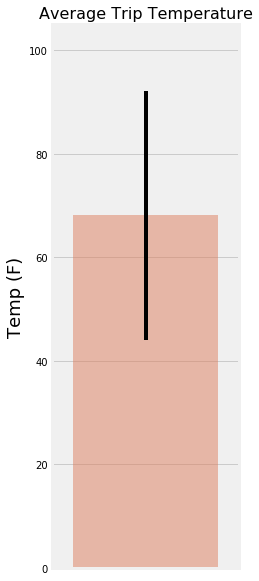

In [20]:
# Bar Graph for Average Vacation Temperature.

Vac_data=calc_temps('2015-03-10', '2015-03-24')
Vac_data_df=pd.DataFrame(list(Vac_data),  \
               columns=('Minimum Vacation Temperature',  \
                        'Average Vacation Temperature',  \
                        'Maximum Vacation Temperature'))



plt.gca().get_xaxis().set_visible(False)
Temp_plot=Vac_data_df['Average Vacation Temperature']. \
        plot(kind='bar', 
             figsize=(3,10),
             yerr=(Vac_data_df["Maximum Vacation Temperature"]- \
             Vac_data_df["Minimum Vacation Temperature"]),\
             
             
             
             color='#de7e5d',
             alpha=0.5,
             ylim=(0,105),
             width=1.7)



plt.title("Average Trip Temperature", fontsize=16)
plt.ylabel("Temp (F)", fontsize=18)
plt.savefig("Trip Avg Temp Bar Graph")
plt.show()

In [21]:
# Merge both datasets together on station name.

# Reference dates: 2014-03-10 to 2014-03-24.

# Interesting to note that station USC00518838 does not
# have any data recorded for this time span so there will
# only be 8 stations with precipitation data.


Vac_perc_merged=session.query(        \
        Measurement.station,          \
        Station.name,                 \
        Station.latitude,             \
        Station.longitude,            \
        Station.elevation,            \
        func.sum(Measurement.prcp)).  \
        filter(Measurement.station==Station.station). \
        filter(Measurement.date>='2014-03-10').       \
        filter(Measurement.date<='2014-03-24').       \
        group_by(Measurement.station).                \
        order_by(func.sum(Measurement.prcp).desc()).  \
        all()



Vac_perc_merged

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.6799999999999997),
 ('USC00517948',
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9,
  2.4299999999999997),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.5500000000000003),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.78),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.36000000000000004),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.16),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.060000000000000005),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.03)]

In [38]:
# Vacation Percipitation query put into a dataframe.
# Looks much better this way.


Vac_perc_merged_df=pd.DataFrame(  \
            Vac_perc_merged, columns=[ \
            "Station ID",
            "Name",
            "Latitude",
            "Longitude",
            "Elevation",
            "Total Precipitation"
            ]
            )



Vac_perc_merged_df

,Station ID,Name,Latitude,Longitude,Elevation,Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.68
1,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.43
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.55
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.78
4,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.36
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.16
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.06
7,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.03


In [40]:
# Each Stations total precipitation for the vacation dates.


Vac_perc_only=Vac_perc_merged_df[["Station ID", "Total Precipitation"]]
Vac_perc_only

,Station ID,Total Precipitation
0,USC00516128,2.68
1,USC00517948,2.43
2,USC00519281,1.55
3,USC00519523,0.78
4,USC00513117,0.36
5,USC00519397,0.16
6,USC00511918,0.06
7,USC00514830,0.03


In [23]:
# Daily Normals Macro...Function.

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()


In [41]:
# Test out the macro:
# Seems to work correctly.

min_v=daily_normals('03-10')[0][0]
avg_v=daily_normals('03-10')[0][1]
max_v=daily_normals('03-10')[0][2]

print(min_v)
print(avg_v)
print(max_v)

57.0
69.12280701754386
75.0


In [42]:
# Vacation data using provided function put into a dataframe.
# These are dates just for specific days however, 2015 is added
# since that will be the year that the vacation dates occur.

Vac_daily_df=pd.DataFrame({
    "Dates": [
             '03-10-2015','03-11-2015','03-12-2015','03-13-2015','03-14-2015',
             '03-15-2015','03-16-2015','03-17-2015','03-18-2015','03-19-2015',
             '03-20-2015','03-21-2015','03-22-2015','03-23-2015','03-24-2015',
             ],
    
    
    
    "Minumum Daily Temperatures": [
                                  daily_normals('03-10')[0][0],
                                  daily_normals('03-11')[0][0],
                                  daily_normals('03-12')[0][0],
                                  daily_normals('03-13')[0][0],
                                  daily_normals('03-14')[0][0],
                                  daily_normals('03-15')[0][0],
                                  daily_normals('03-16')[0][0],
                                  daily_normals('03-17')[0][0],
                                  daily_normals('03-18')[0][0],
                                  daily_normals('03-19')[0][0],
                                  daily_normals('03-20')[0][0],
                                  daily_normals('03-21')[0][0],
                                  daily_normals('03-22')[0][0],
                                  daily_normals('03-23')[0][0],
                                  daily_normals('03-24')[0][0]
                                  ],
    
    
    
    "Average Daily Temperatures": [
                                  daily_normals('03-10')[0][1],
                                  daily_normals('03-11')[0][1],
                                  daily_normals('03-12')[0][1],
                                  daily_normals('03-13')[0][1],
                                  daily_normals('03-14')[0][1],
                                  daily_normals('03-15')[0][1],
                                  daily_normals('03-16')[0][1],
                                  daily_normals('03-17')[0][1],
                                  daily_normals('03-18')[0][1],
                                  daily_normals('03-19')[0][1],
                                  daily_normals('03-20')[0][1],
                                  daily_normals('03-21')[0][1],
                                  daily_normals('03-22')[0][1],
                                  daily_normals('03-23')[0][1],
                                  daily_normals('03-24')[0][1]
                                  ],  
    
    
    
    "Maximum Daily Temperatures": [
                                  daily_normals('03-10')[0][2],
                                  daily_normals('03-11')[0][2],
                                  daily_normals('03-12')[0][2],
                                  daily_normals('03-13')[0][2],
                                  daily_normals('03-14')[0][2],
                                  daily_normals('03-15')[0][2],
                                  daily_normals('03-16')[0][2],
                                  daily_normals('03-17')[0][2],
                                  daily_normals('03-18')[0][2],
                                  daily_normals('03-19')[0][2],
                                  daily_normals('03-20')[0][2],
                                  daily_normals('03-21')[0][2],
                                  daily_normals('03-22')[0][2],
                                  daily_normals('03-23')[0][2],
                                  daily_normals('03-24')[0][2]
                                  ], 
                        }
                        )



Vac_daily_df=Vac_daily_df.set_index(['Dates'])
Vac_daily_df.head()

,Minumum Daily Temperatures,Average Daily Temperatures,Maximum Daily Temperatures
Dates,,,
03-10-2015,57.0,69.122807,75.0
03-11-2015,60.0,69.892857,82.0
03-12-2015,62.0,69.888889,80.0
03-13-2015,56.0,69.296296,77.0
03-14-2015,62.0,70.327586,77.0


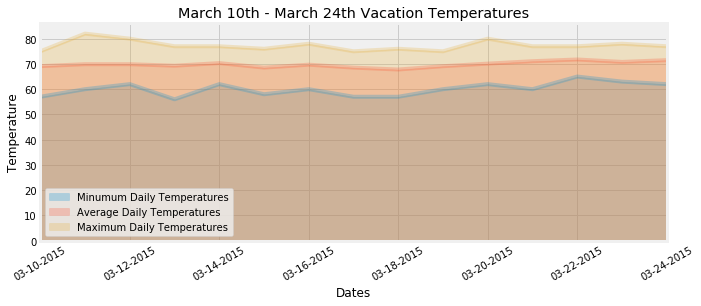

In [47]:
# Area Plot.  Pretty cool and surprisingly simple.

Area_plot=Vac_daily_df.plot(  \
    kind='area', stacked=False, alpha=0.25, rot=30, figsize=(10,4)
    )



plt.title("March 10th - March 24th Vacation Temperatures")
plt.ylabel("Temperature")
plt.savefig('Vacation Area Plot')
plt.show()